In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.preprocessing import image_dataset_from_directory

print('TensorFlow', tf.__version__)

TensorFlow 2.10.0


In [3]:
DATA_DIR = '../data'   # change to the parent folder that contains 'train' and 'test' or 'train' only
TRAIN_SUBDIR = 'train' # or 'images_train'
TEST_SUBDIR = 'test'   # optional if you have a separate test folder
IMG_SIZE = (100, 100)  # input size used previously
BATCH_SIZE = 32
SEED = 1337
AUTOTUNE = tf.data.AUTOTUNE
NUM_EPOCHS = 30
NUM_CLASSES = None

In [4]:
train_dir = os.path.join(DATA_DIR, TRAIN_SUBDIR)
test_dir = os.path.join(DATA_DIR, TEST_SUBDIR) if os.path.isdir(os.path.join(DATA_DIR, TEST_SUBDIR)) else None

In [5]:
# If you don't have a separate test folder, we use validation_split
if test_dir is None:
    train_ds = image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='categorical',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        color_mode='grayscale',
        validation_split=0.2,
        subset='training',
        seed=SEED
    )
    val_ds = image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='categorical',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        color_mode='grayscale',
        validation_split=0.2,
        subset='validation',
        seed=SEED
    )
else:
    train_ds = image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='categorical',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        color_mode='grayscale',
        seed=SEED
    )
    val_ds = image_dataset_from_directory(
        test_dir,
        labels='inferred',
        label_mode='categorical',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        color_mode='grayscale',
        seed=SEED
    )

Found 28800 files belonging to 36 classes.
Found 7236 files belonging to 36 classes.


In [6]:
class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print('Classes:', class_names)

Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [7]:
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Build a normalization layer (scales to [0,1])
normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.06),
    layers.RandomZoom(0.08),
    layers.RandomTranslation(0.06, 0.06)
], name='data_augmentation')

In [ ]:
def build_model(input_shape=(*IMG_SIZE, 1), num_classes=NUM_CLASSES):
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)                  
    x = normalization_layer(x)
    
    # Block 1
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    
    # Block 2
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    
    # Block 3
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs, name='cnn_isl')
    return model

model = build_model()
model.summary()

Model: "cnn_isl"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 100, 100, 1)      0         
 al)                                                             
                                                                 
 rescaling (Rescaling)       (None, 100, 100, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0   

In [9]:
# Compile model with a small weight decay via AdamW-style optimizer
optimizer = optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Callbacks: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
checkpoint_cb = callbacks.ModelCheckpoint('best_cnn_isl.h5', save_best_only=True, monitor='val_loss')
earlystop_cb = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)

cbs = [checkpoint_cb, earlystop_cb, reduce_lr]

In [10]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS,
    callbacks=cbs
)

Epoch 1/30
900/900 [==============================] - 562s 613ms/step - loss: 2.6113 - accuracy: 0.2561 - val_loss: 3.5848 - val_accuracy: 0.1551 - lr: 0.0010
Epoch 2/30
900/900 [==============================] - 327s 363ms/step - loss: 1.2413 - accuracy: 0.6135 - val_loss: 2.5987 - val_accuracy: 0.2774 - lr: 0.0010
Epoch 3/30
900/900 [==============================] - 302s 335ms/step - loss: 0.7221 - accuracy: 0.7665 - val_loss: 2.2789 - val_accuracy: 0.3554 - lr: 0.0010
Epoch 4/30
900/900 [==============================] - 300s 334ms/step - loss: 0.5318 - accuracy: 0.8232 - val_loss: 4.9660 - val_accuracy: 0.1707 - lr: 0.0010
Epoch 5/30
900/900 [==============================] - 301s 334ms/step - loss: 0.4440 - accuracy: 0.8519 - val_loss: 5.3356 - val_accuracy: 0.1708 - lr: 0.0010
Epoch 6/30
900/900 [==============================] - 300s 333ms/step - loss: 0.3834 - accuracy: 0.8685 - val_loss: 2.3229 - val_accuracy: 0.4432 - lr: 0.0010
Epoch 7/30
900/900 [==========================

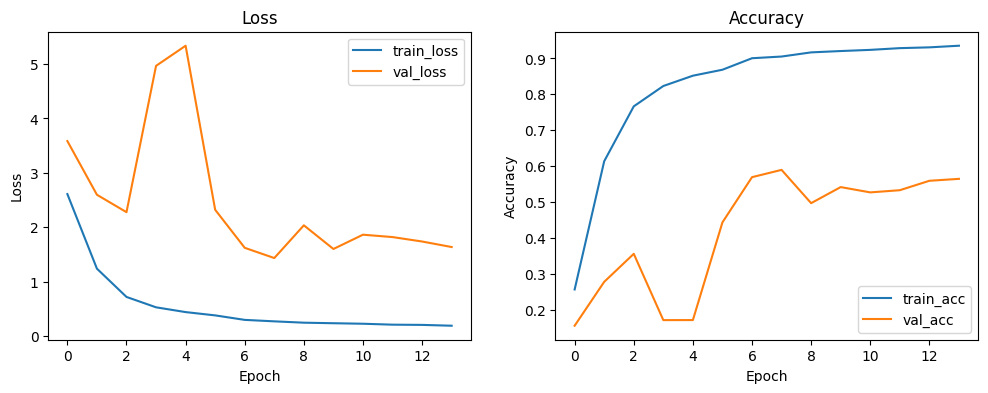

In [11]:
# Plot training & validation accuracy and loss
import matplotlib.pyplot as plt
hist = history.history

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist['loss'], label='train_loss')
plt.plot(hist['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(hist['accuracy'], label='train_acc')
plt.plot(hist['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.show()

In [12]:
# Evaluate on validation/test set
val_loss, val_acc = model.evaluate(val_ds)
print(f'Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}')

227/227 [==============================] - 2s 7ms/step - loss: 1.4365 - accuracy: 0.5894
Validation loss: 1.4365, Validation accuracy: 0.5894


In [13]:
# Get predictions and build confusion matrix
# Collect all images and labels from val_ds
y_true = []
y_pred = []
for x_batch, y_batch in val_ds:
    preds = model.predict(x_batch)
    y_true.extend(np.argmax(y_batch, axis=1).tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())

cm = confusion_matrix(y_true, y_pred)
print('Confusion matrix shape:', cm.shape)

1/1 [==============================] - 0s 290ms/step
Confusion matrix shape: (36, 36)


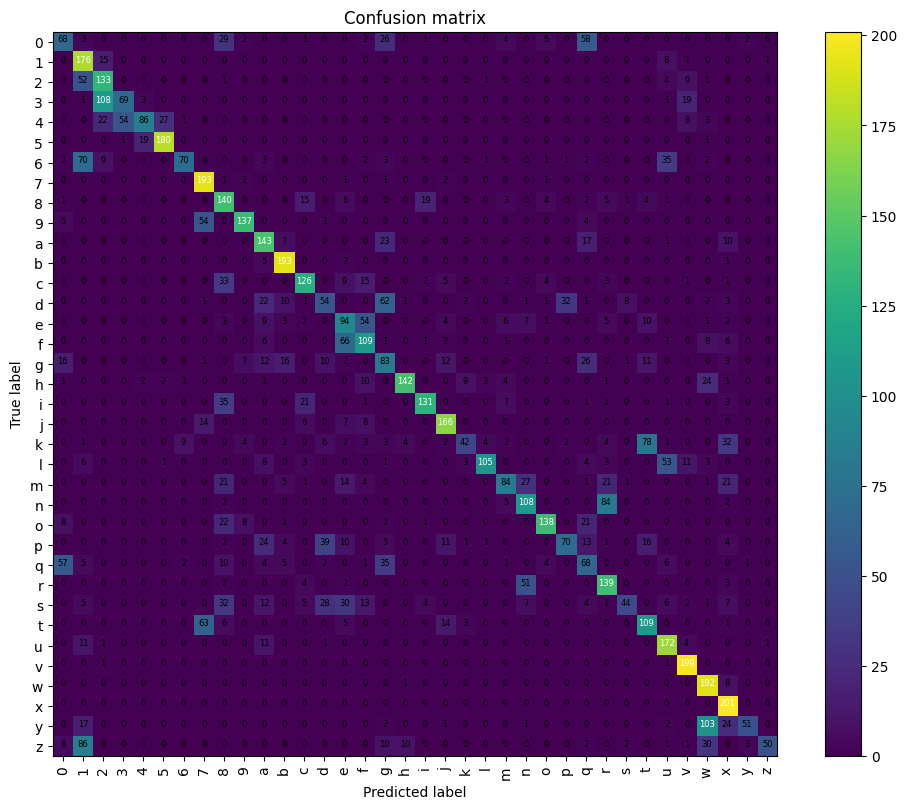

In [14]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    plt.figure(figsize=(10,8))
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-12)
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        val = cm[i, j]
        if normalize:
            fmt = '{:.2f}'.format(val)
        else:
            fmt = str(int(val))
        plt.text(j, i, fmt, horizontalalignment='center',
                    color='white' if val > thresh else 'black', fontsize=6)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm, class_names, normalize=False)
plt.show()

In [15]:
# Classification report (per-class precision/recall/f1)
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

              precision    recall  f1-score   support

           0       0.41      0.34      0.37       201
           1       0.41      0.88      0.56       201
           2       0.46      0.66      0.54       201
           3       0.56      0.34      0.42       201
           4       0.78      0.43      0.55       201
           5       0.86      0.90      0.88       201
           6       0.84      0.35      0.49       201
           7       0.59      0.96      0.73       201
           8       0.41      0.70      0.52       201
           9       0.86      0.68      0.76       201
           a       0.55      0.71      0.62       201
           b       0.78      0.96      0.86       201
           c       0.68      0.63      0.65       201
           d       0.38      0.27      0.32       201
           e       0.38      0.47      0.42       201
           f       0.49      0.54      0.52       201
           g       0.32      0.41      0.36       201
           h       0.90    